In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor,RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import seaborn as sns
from pyod.models.mad import MAD
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RandomizedSearchCV

In [113]:
#Load the data
X_train_unfiltered =np.load('X_train.npy')
Y_train_unfiltered =np.load('y_train.npy')
X_test =np.load('X_test.npy')

In [114]:
# Create a dataframe for the training data and standardize the features
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']
#Define the colours for the plots associated with each feature
colours = ['deepskyblue', 'aqua', 'mediumvioletred', 'teal', "gold"]
scaler = StandardScaler()
X_train_unfiltered = scaler.fit_transform(X_train_unfiltered)
X_train_unfiltered = pd.DataFrame(X_train_unfiltered)
X_train_unfiltered = X_train_unfiltered.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train_unfiltered)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data_unfiltered = X_train_unfiltered.copy()
train_data_unfiltered['Y_train'] = y_train_df.reset_index(drop=True)

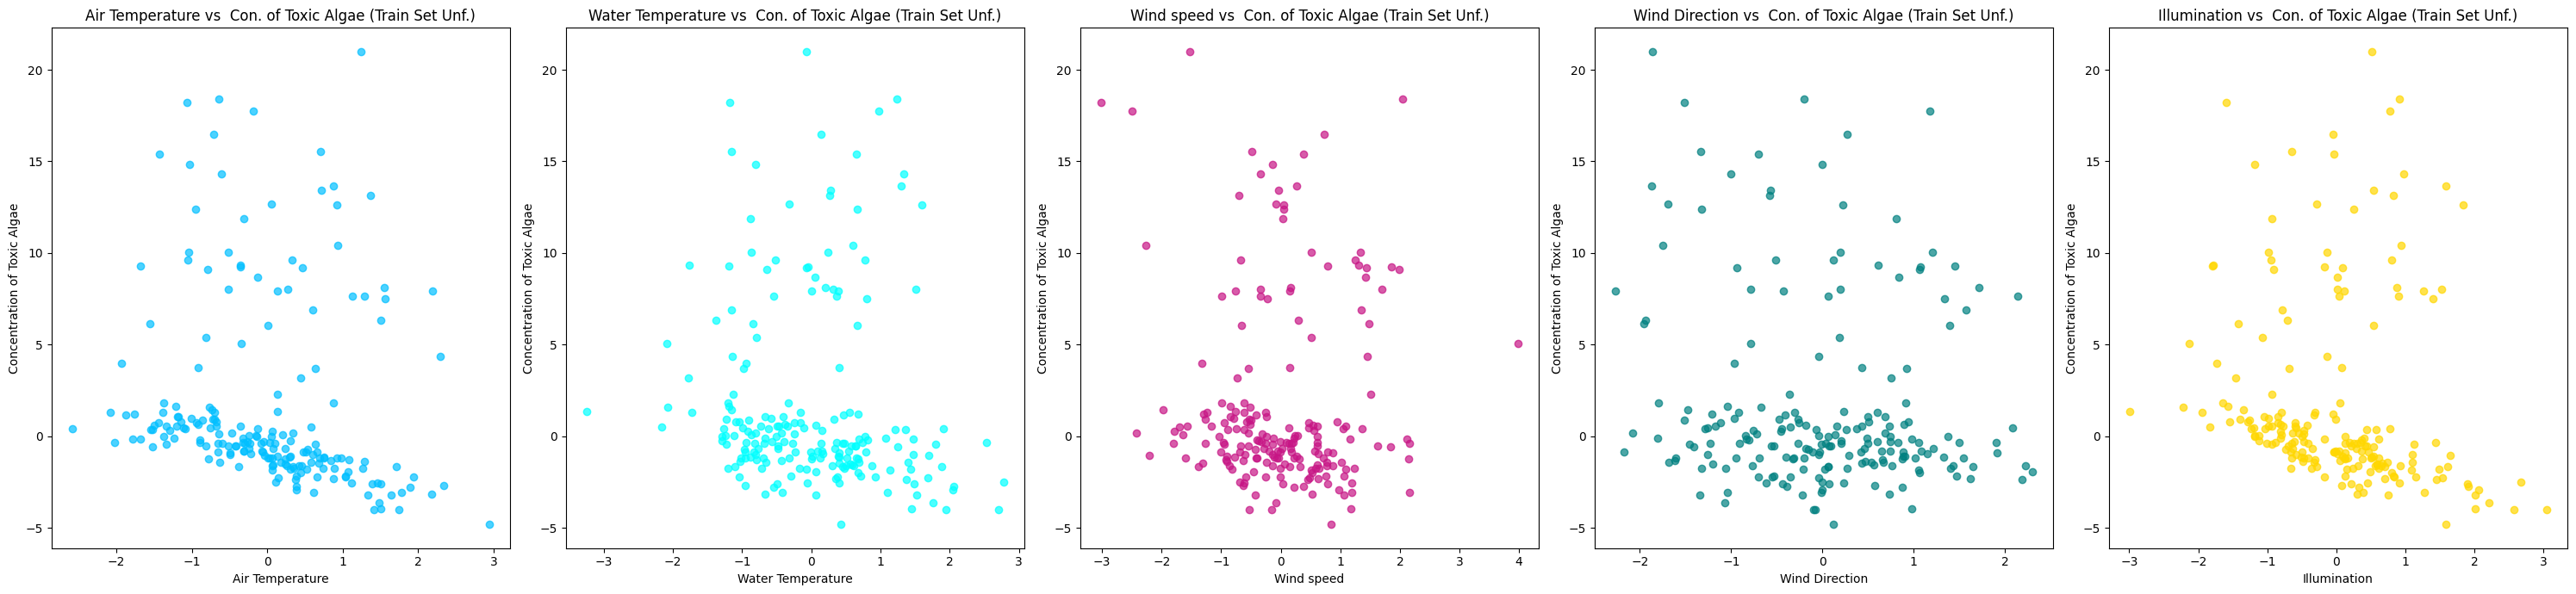

In [115]:
# Plots with training data with outliers to visualize the data
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(train_data_unfiltered[feature], train_data_unfiltered['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set Unf.)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

**Ordinary Linear Regression for Outliers**

In [116]:
linear_model = LinearRegression()

linear_model.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_OLS = linear_model.predict(train_data_unfiltered[train_features])
residuals = np.square(train_data_unfiltered['Y_train'] - y_pred_OLS)
threshold = np.percentile(residuals, 75)
least_residual_points_OLS = train_data_unfiltered[residuals < threshold]
X_train, X_val, Y_train, Y_val = train_test_split(least_residual_points_OLS[train_features],least_residual_points_OLS['Y_train'],test_size=0.3, random_state=42)


MSE of OLS: 0.8687961017689586


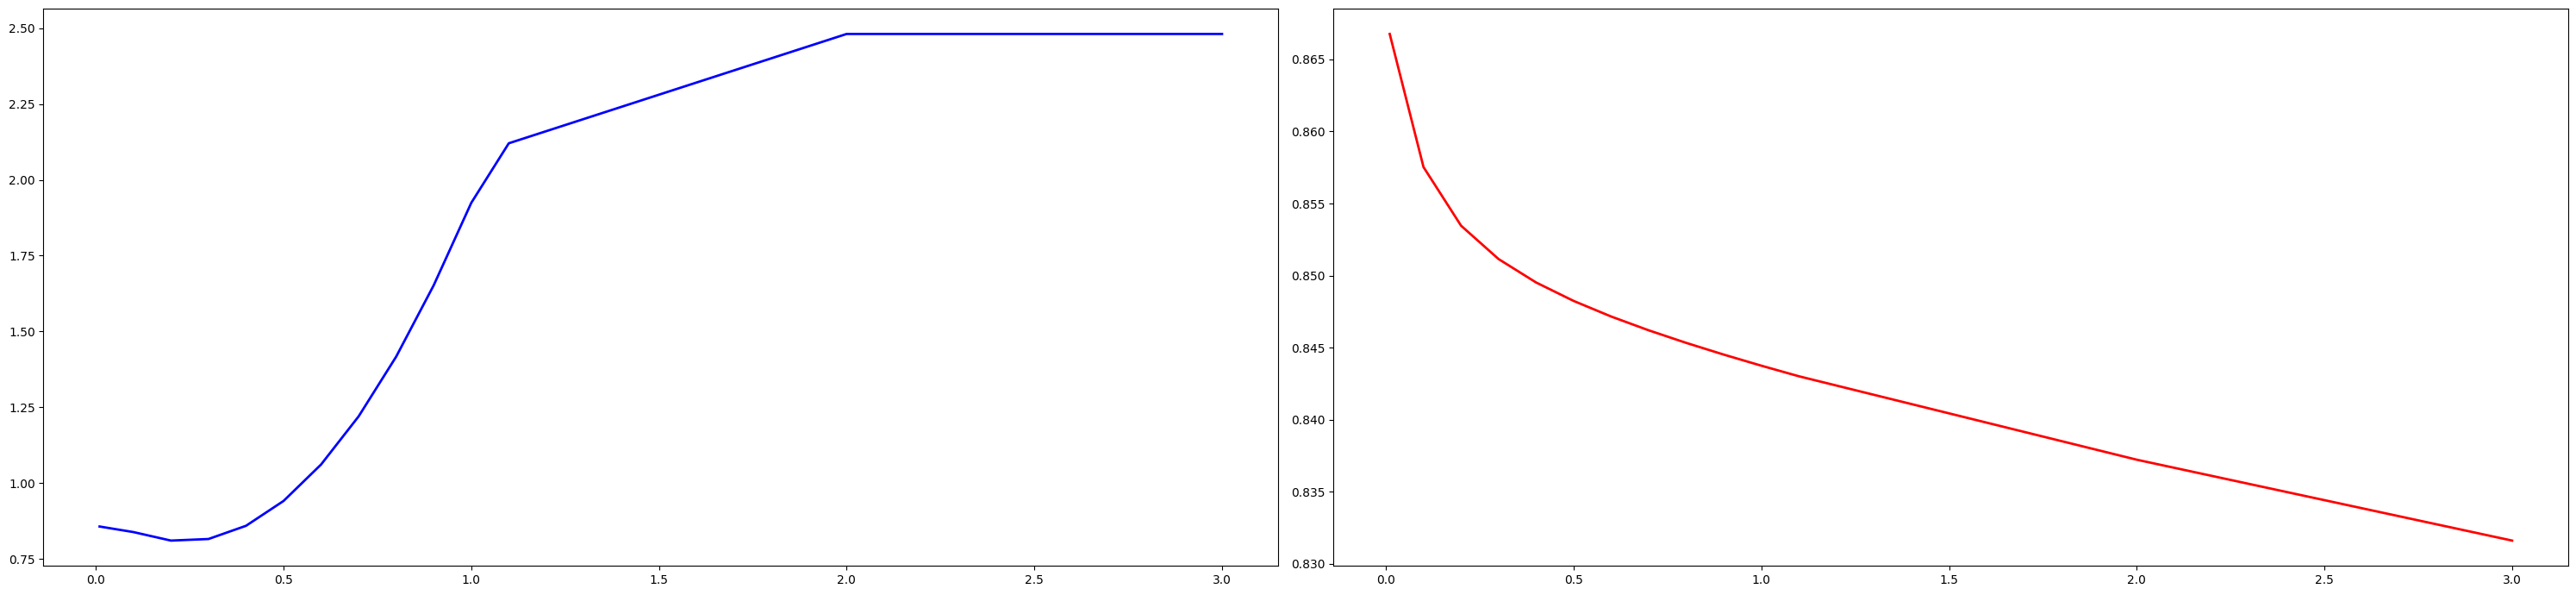

    Alpha  L1_Ratio       MSE
33    0.3      0.01  0.775436
34    0.3      0.10  0.777650
22    0.2      0.01  0.779950
23    0.2      0.10  0.781194
44    0.4      0.01  0.781768


In [117]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
y_pred_OLS = lr.predict(X_val)
print(f"MSE of OLS: {mean_squared_error(Y_val, y_pred_OLS)}")

alpha = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3]

ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(X_train, Y_train)
    y_pred_lasso = lasso.predict(X_val)
    lasso_mse = mean_squared_error(Y_val, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i])
    ridge.fit(X_train, Y_train)
    y_pred_ridge = ridge.predict(X_val)
    ridge_mse = mean_squared_error(Y_val, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(X_train, Y_train)
        y_pred_en = en.predict(X_val)
        en_mse = mean_squared_error(Y_val, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

RANSAC Outlier detection

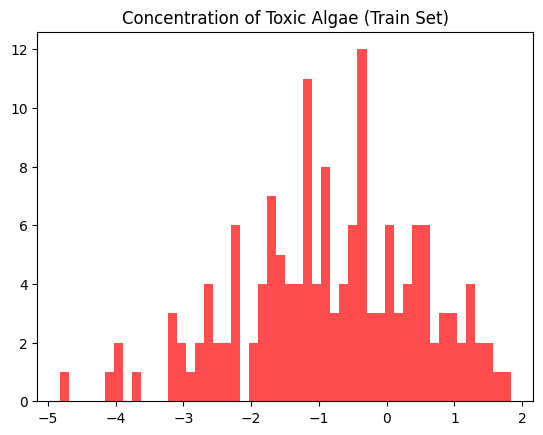

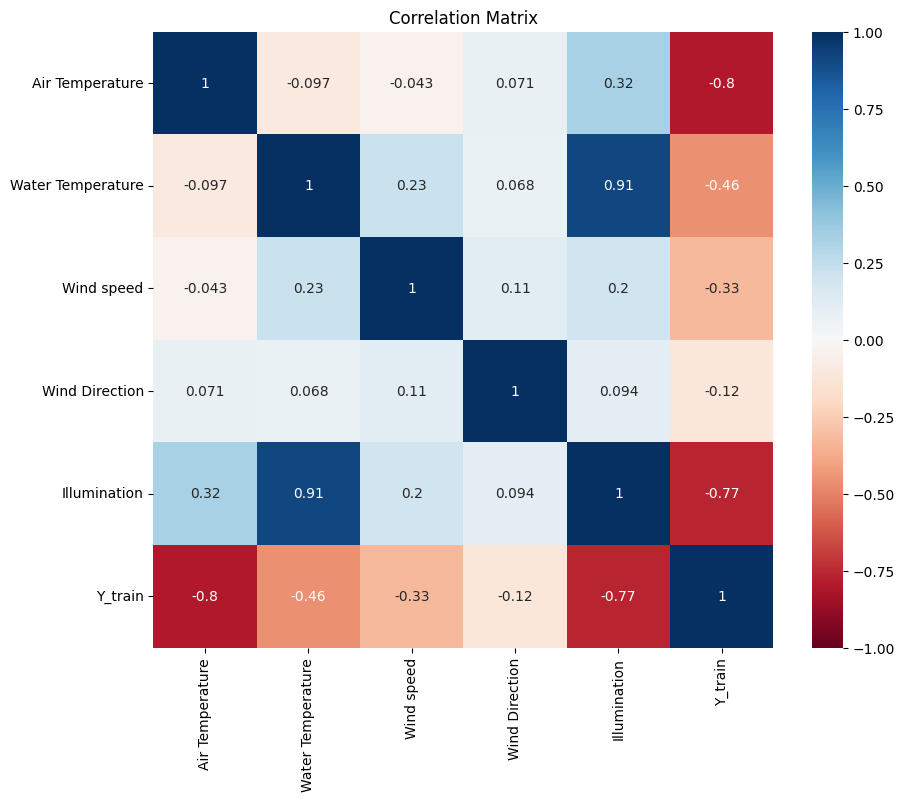

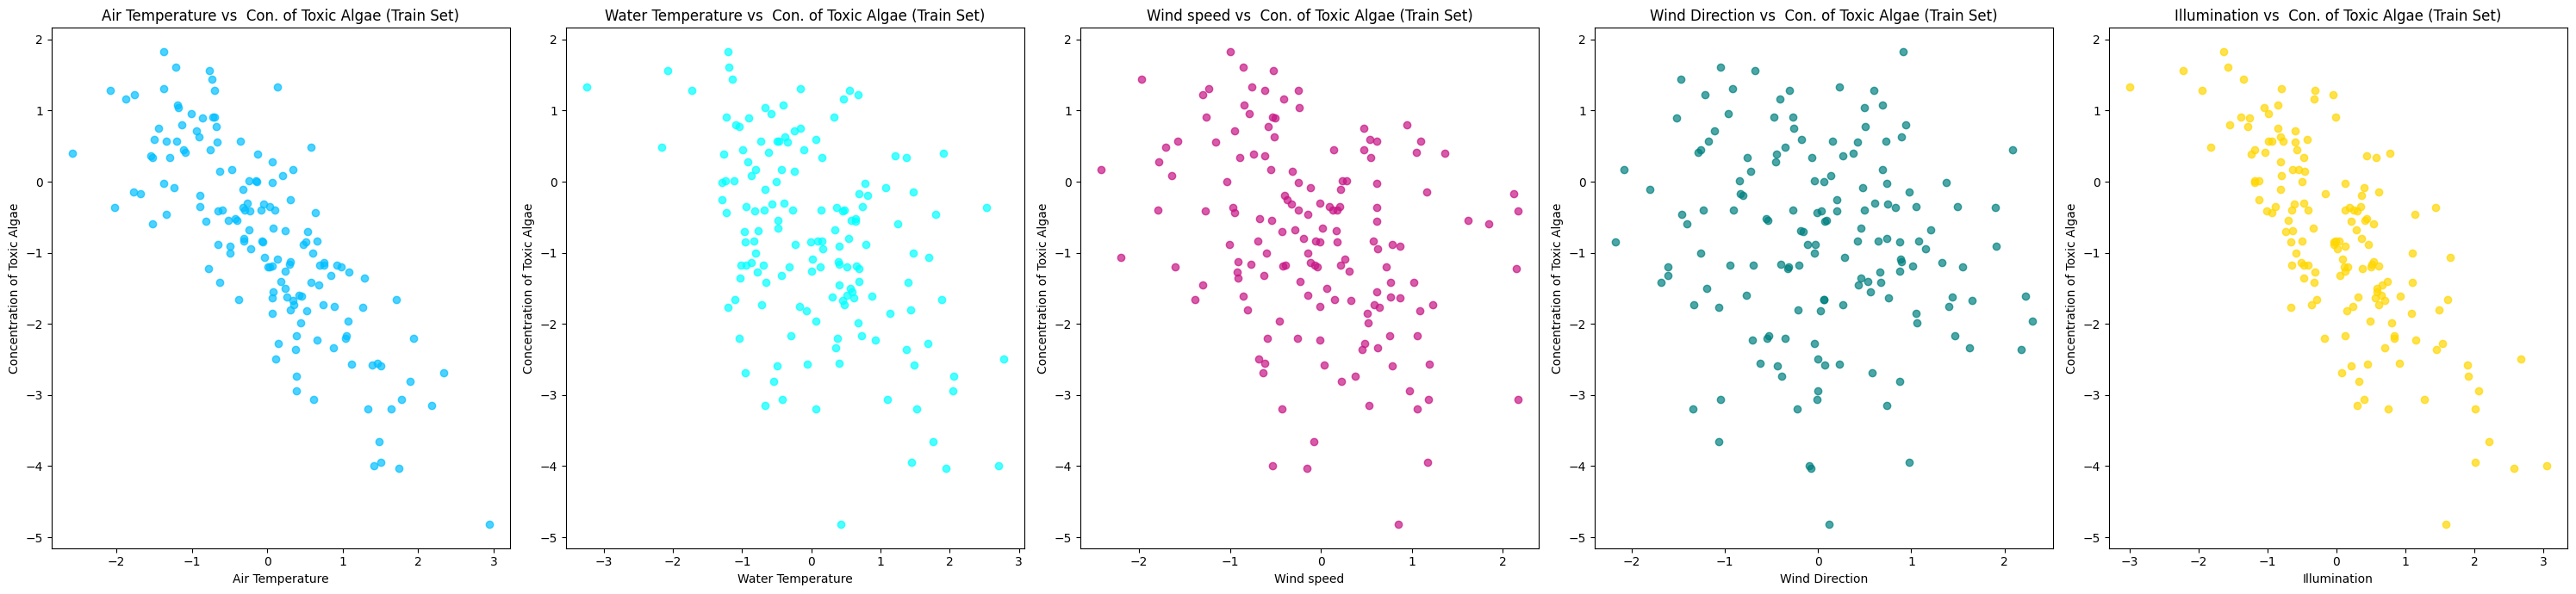

In [118]:
ransac = RANSACRegressor(
    estimator=LinearRegression(), 
    stop_n_inliers= 150, 
    random_state=42
)

ransac.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])

inlier_mask = ransac.inlier_mask_

train_data_RANSAC = train_data_unfiltered[inlier_mask]
train_data_RANSAC = train_data_RANSAC.reset_index(drop=True)

plt.hist(train_data_RANSAC['Y_train'], bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.show()

correlation_matrix = train_data_RANSAC.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(train_data_RANSAC[feature], train_data_RANSAC['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

In [119]:
X_train, X_val, Y_train, Y_val = train_test_split(train_data_RANSAC[train_features],train_data_RANSAC['Y_train'],test_size=0.3, random_state=42)

MSE of OLS: 0.015519123104318374


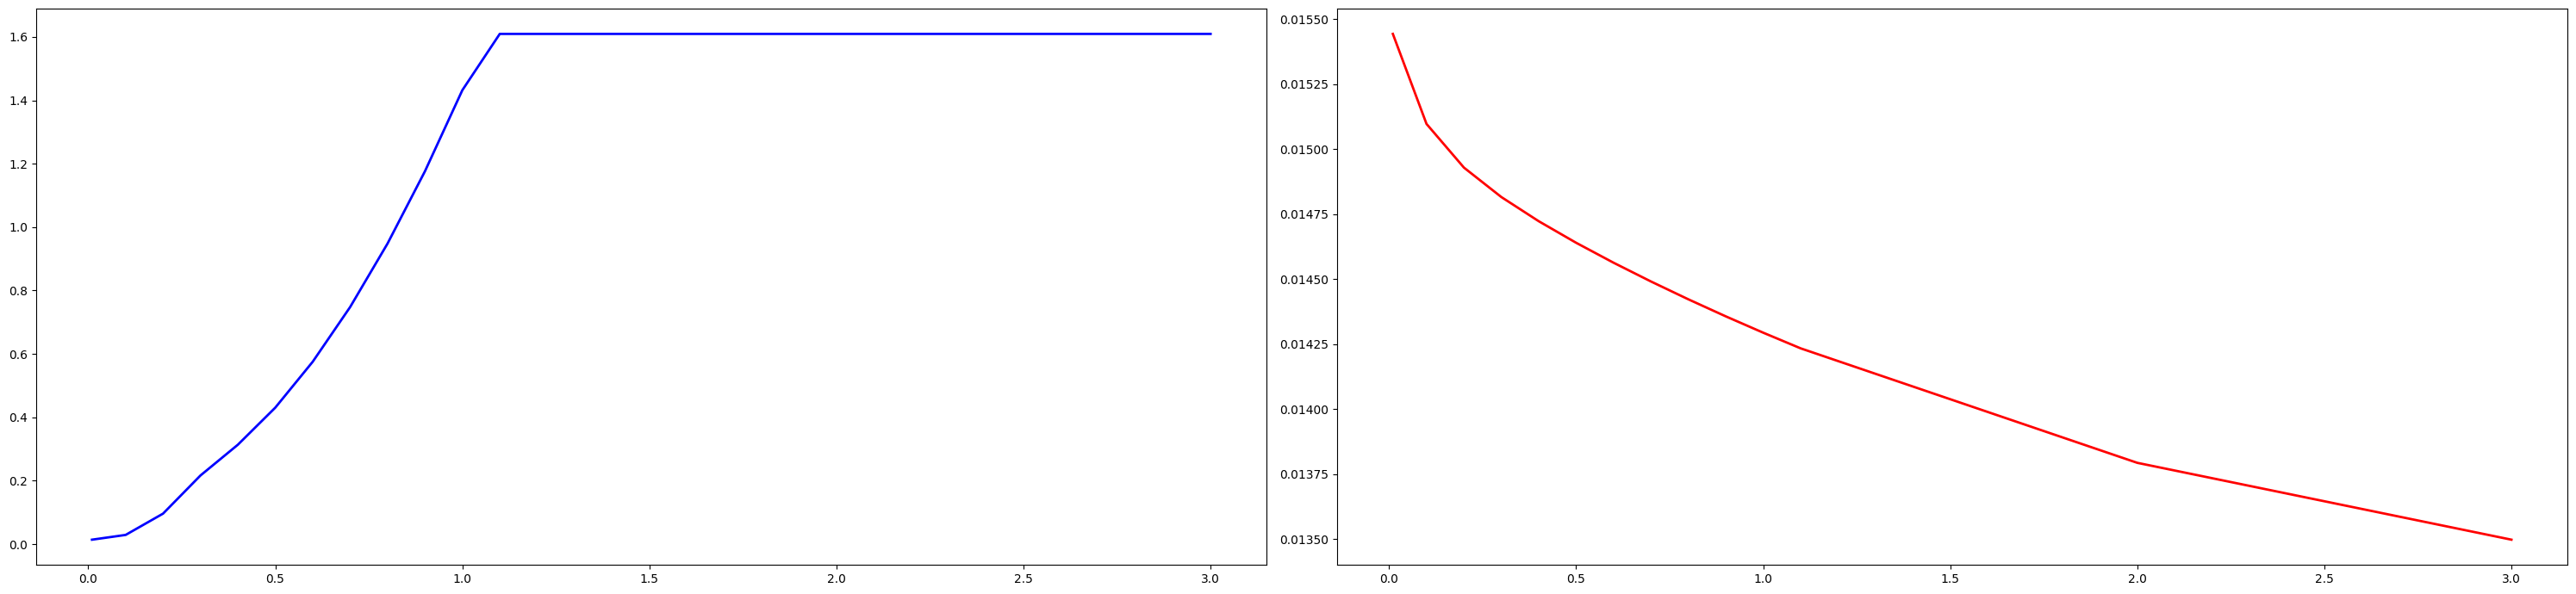

    Alpha  L1_Ratio       MSE
10   0.01       1.0  0.013972
9    0.01       0.9  0.013986
8    0.01       0.8  0.014000
7    0.01       0.7  0.014012
6    0.01       0.6  0.014028


In [120]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
y_pred_OLS = lr.predict(X_val)
print(f"MSE of OLS: {mean_squared_error(Y_val, y_pred_OLS)}")

alpha = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3]

ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(X_train, Y_train)
    y_pred_lasso = lasso.predict(X_val)
    lasso_mse = mean_squared_error(Y_val, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i])
    ridge.fit(X_train, Y_train)
    y_pred_ridge = ridge.predict(X_val)
    ridge_mse = mean_squared_error(Y_val, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(X_train, Y_train)
        y_pred_en = en.predict(X_val)
        en_mse = mean_squared_error(Y_val, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

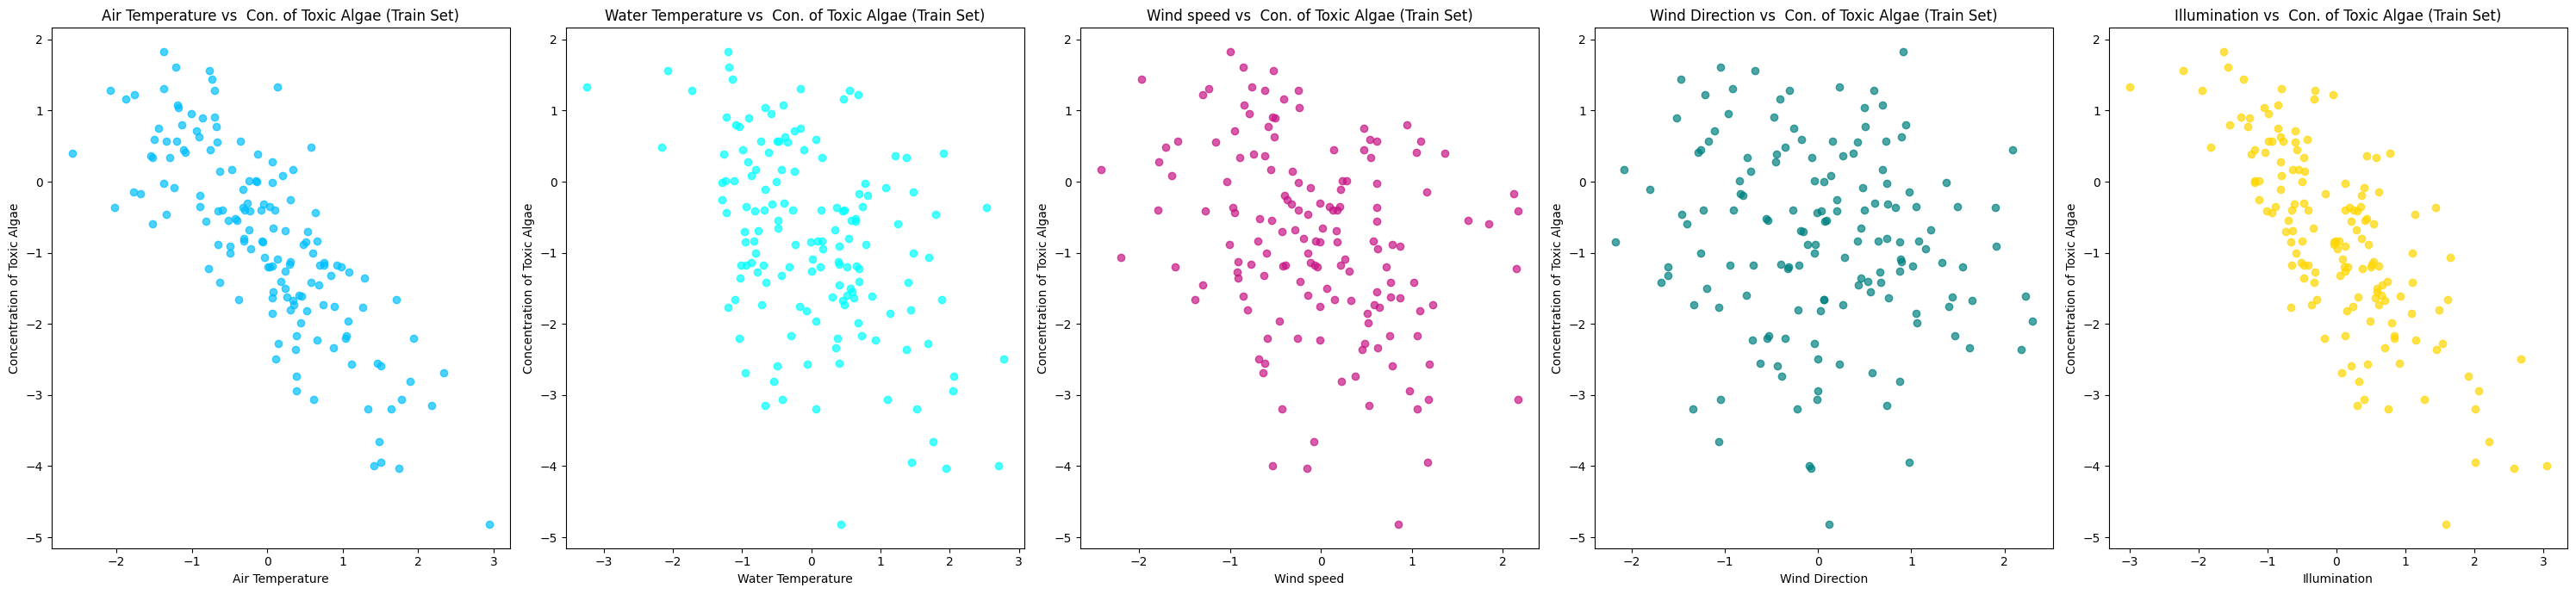

In [121]:
HuberRegressor = HuberRegressor()
HuberRegressor.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_HR = HuberRegressor.predict(train_data_unfiltered[train_features])
residuals = np.square(train_data_unfiltered['Y_train'] - y_pred_HR)
threshold = np.percentile(residuals, 75)
least_residual_points = train_data_unfiltered[residuals < threshold]
X_train, X_val, Y_train, Y_val = train_test_split(least_residual_points[train_features],least_residual_points['Y_train'],test_size=0.3, random_state=42)
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(least_residual_points[feature], least_residual_points['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of OLS: 0.00024909491307047117
[-1.0725228  -0.46426409 -0.3690931  -0.         -0.18355055]
0.00032234694530024335
[-0.85510842 -0.         -0.35813088 -0.         -0.68045003]
0.0015565959371646463
[-0.77243088 -0.         -0.26318274 -0.         -0.62486535]
0.02580563772084961
[-0.68055209 -0.         -0.15767481 -0.         -0.56311145]
0.10089342148821981
[-0.58868044 -0.         -0.05217169 -0.         -0.50135425]
0.2266541723407921
[-0.50412817 -0.         -0.         -0.         -0.42529077]
0.38265282682171586
[-0.42673705 -0.         -0.         -0.         -0.33523181]
0.5633618158697651
[-0.34934262 -0.         -0.         -0.         -0.24517388]
0.7868155308028274
[-0.27195297 -0.         -0.         -0.         -0.15511446]
1.0530069815051013
[-0.19455981 -0.         -0.         -0.         -0.06505614]
1.3619438917365252
[-0.11019186 -0.         -0.         -0.         -0.        ]
1.6689209272579069
[-0.00767535 -0.         -0.         -0.         -0.        ]
1.

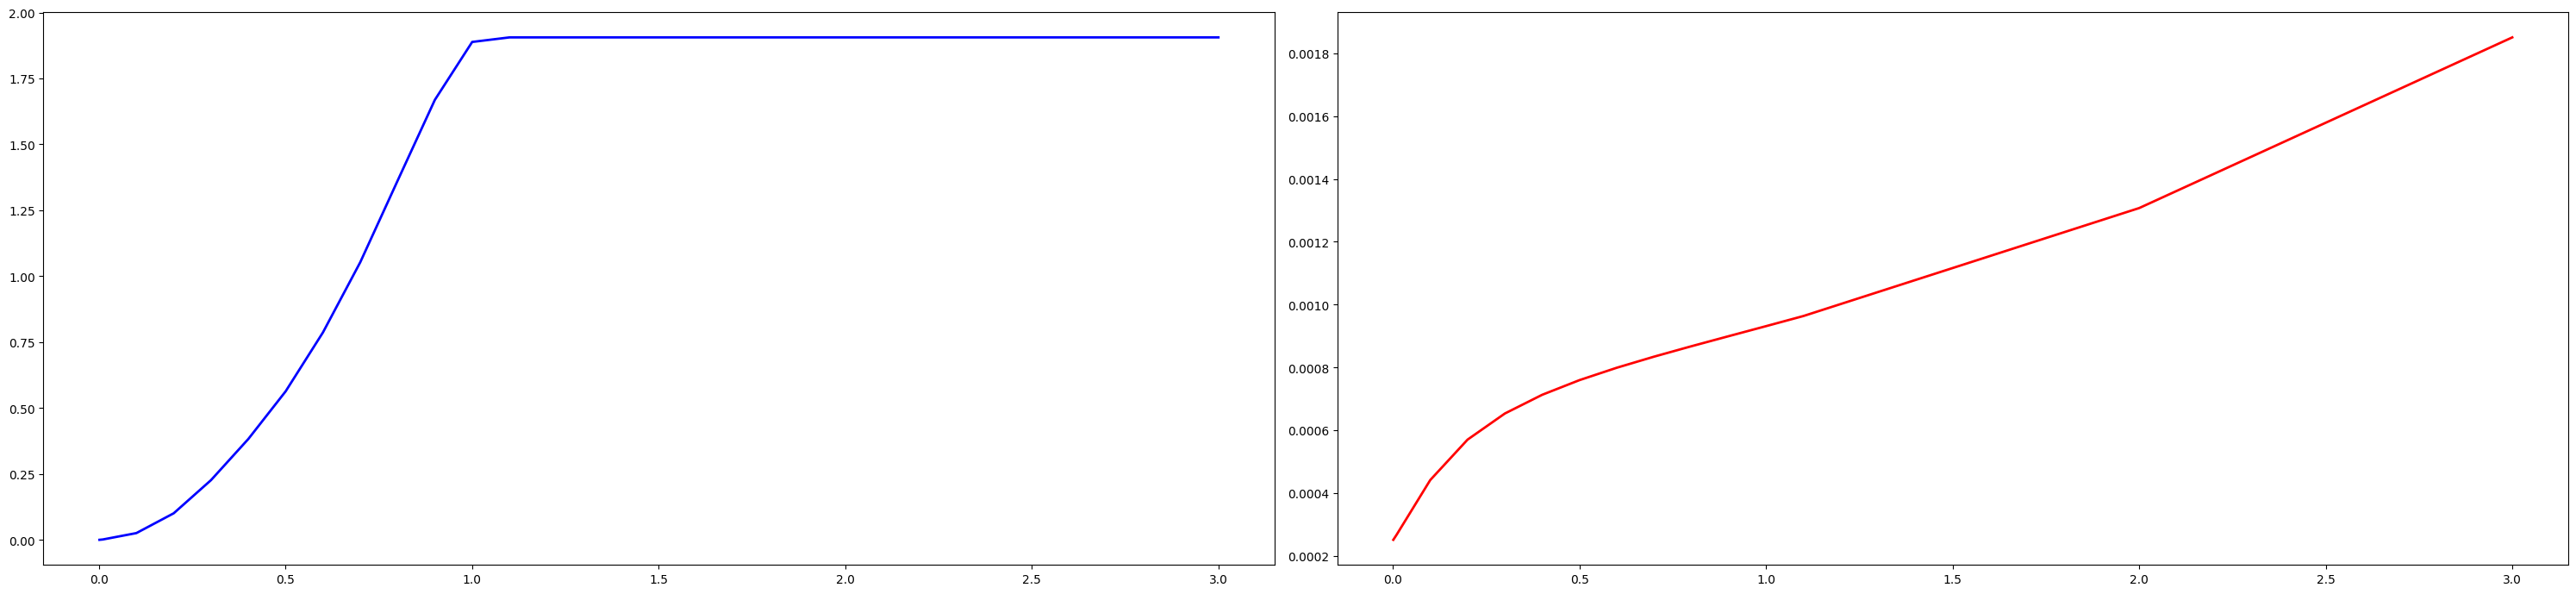

    Alpha  L1_Ratio       MSE
10  0.001       1.0  0.000322
9   0.001       0.9  0.000336
8   0.001       0.8  0.000348
7   0.001       0.7  0.000360
6   0.001       0.6  0.000371


In [122]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred_OLS = lr.predict(X_val)
print(f"MSE of OLS: {mean_squared_error(Y_val, y_pred_OLS)}")

alpha = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3]

ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(X_train, Y_train)
    y_pred_lasso = lasso.predict(X_val)
    lasso_mse = mean_squared_error(Y_val, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    print(lasso.coef_)
    print(mean_squared_error(Y_val, y_pred_lasso))
    ridge = Ridge(alpha=alpha[i])
    ridge.fit(X_train, Y_train)
    y_pred_ridge = ridge.predict(X_val)
    ridge_mse = mean_squared_error(Y_val, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(X_train, Y_train)
        y_pred_en = en.predict(X_val)
        en_mse = mean_squared_error(Y_val, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

**Cross-validation**

In [131]:
# Initialize the RidgeCV model with the list of alpha values
ridge_cv_model = RidgeCV(alphas=alpha, store_cv_results=True)

# Fit the model to the training data
ridge_cv_model.fit(X_train, Y_train)

# Access the best alpha value chosen during cross-validation
best_alpha = ridge_cv_model.alpha_
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values = ridge_cv_model.cv_results_
cv_df = pd.DataFrame(cv_values, columns=[f'Alpha: {alpha}' for alpha in alpha])

# Display the cross-validation values
print("\nCross-Validation MSE for each alpha and fold:")
print(cv_df.head())

# Make predictions on the test set
y_pred = ridge_cv_model.predict(X_test)

# Evaluate the model performance (e.g., R^2 score)
r2_score = ridge_cv_model.score(X_val, Y_val)
print(f"\nR² score on test data: {r2_score}")


Best alpha: 0.001

Cross-Validation MSE for each alpha and fold:
   Alpha: 0.001  Alpha: 0.01  Alpha: 0.1  Alpha: 0.2  Alpha: 0.3  Alpha: 0.4  \
0      0.000281     0.000246    0.000095    0.000048    0.000028    0.000018   
1      0.000125     0.000147    0.000302    0.000388    0.000435    0.000462   
2      0.000202     0.000184    0.000097    0.000064    0.000047    0.000036   
3      0.000021     0.000030    0.000098    0.000133    0.000146    0.000147   
4      0.000297     0.000298    0.000309    0.000328    0.000348    0.000370   

   Alpha: 0.5  Alpha: 0.6  Alpha: 0.7  Alpha: 0.8  Alpha: 0.9  Alpha: 1  \
0    0.000012    0.000008    0.000005    0.000003    0.000002  0.000001   
1    0.000479    0.000489    0.000495    0.000498    0.000499  0.000499   
2    0.000029    0.000023    0.000018    0.000015    0.000011  0.000009   
3    0.000142    0.000134    0.000124    0.000113    0.000102  0.000091   
4    0.000393    0.000417    0.000442    0.000468    0.000494  0.000521   

   

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
